In [28]:
#-------------------------------------------------------------------------------
# Name:        Deep Convolutional Neural Network (DCNN) for slum mapping
# Purpose:     Test DCNN on mapping degrees of deprivation
#              Main method is ...

# Version:     0.1 
#              Functionalities:
#              1.
#              2.
#              3.
#              4.

# Author:      Jiong (Jon) Wang
#
# Created:     26/05/2020
# Copyright:   (c) JonWang 2020
# Licence:     <your licence>
#-------------------------------------------------------------------------------


from keras import backend as K
from keras.models import Model, model_from_json, load_model
from keras import optimizers
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.layers import (
    Conv2D,
    UpSampling2D,
    MaxPooling2D,
    Input,
    Conv2DTranspose,
    Flatten,
    BatchNormalization,
    Activation,
    concatenate
)
from keras.layers.core import RepeatVector, Reshape
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from scipy import interpolate
from osgeo import gdal_array
from pathlib import Path
from functools import partial
from sklearn.metrics import jaccard_similarity_score as jaccard_score
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf



Using TensorFlow backend.


In [29]:

##############################################
# 01 Load and organize images
##############################################

# load rasters: base image along with its label
# Stack base image and label into a list of array
def load_rasters(path, subUL, band_ind):  # Subset from original raster with extent and upperleft coord
    """Load training data pairs (two high resolution images and two low resolution images)"""
    file_list = []  # List image name
    for file in Path(path).glob('*.tif'):
        file_list.append(file)
    assert len(file_list) == 2

    # Ensure the order of the list: base image first !!
    for file in file_list:  # Organize file list
        img_name = file.name
        if 'base' in img_name:
            base = file
        elif 'label' in img_name:
            label = file
    file_list = [base, label]
    
    stack = []  # Stack base and label together into a 3D array
    for file in file_list:
        if file.name.startswith('base'):
            data = gdal_array.LoadFile(str(file), xoff=subUL[0], yoff=subUL[1]) #.astype(np.int),ysize=extent[1],xsize=extent[0]
            data = data[tuple(band_ind),:,:]  # Worldview image with 3rd dimension at first
            data = np.transpose(data,(1,2,0))  # Transpose 3rd to last 
            stack.append(data)
        else:
            data = gdal_array.LoadFile(str(file), xoff=subUL[0], yoff=subUL[1]) #.astype(np.int),xsize=extent[0],ysize=extent[1]
            data = data[:,:,np.newaxis]
            stack.append(data)
#        image = Image.fromarray(data)
#        data = nan_remover(data)
#        setattr(image, 'filename', file)
    # Ensure the size of base and label is are consistent
    assert stack[0].shape[0] == stack[-1].shape[0]
    assert stack[0].shape[1] == stack[-1].shape[1]
    return stack[:-1], stack[-1]


# Clean the NaN values
def nan_remover(array):
    x = np.arange(0, array.shape[1])
    y = np.arange(0, array.shape[0])
    # Masking invalid values
    array = np.ma.masked_invalid(array)
    xx, yy = np.meshgrid(x, y)
    # Getting only the valid values
    x1 = xx[~array.mask]
    y1 = yy[~array.mask]
    newarr = array[~array.mask]
    array_interp = interpolate.griddata((x1, y1), newarr.ravel(),
                              (xx, yy), method='nearest')
    # Clean the edge
    bad_indexes = np.isnan(array_interp)
    good_indexes = np.logical_not(bad_indexes)
    good_data = array_interp[good_indexes]
    interpolated = np.interp(bad_indexes.nonzero()[0], good_indexes.nonzero()[0], good_data)
    array_interp[bad_indexes] = interpolated
    return array_interp



In [30]:

##############################################
# 02 Prepare data for train, val, test
##############################################

# Sample patches from an image band/layer
# Stride controls the overlap of patches
def gen_patches(image, size, stride):
    """Segment input images into patches"""
    if not isinstance(size, tuple):  # Ensure format is tuple
        size = (size, size)
    if stride is None:
        stride = size
    elif not isinstance(stride, tuple):
        stride = (stride, stride)
    # Columns in priority
    for i in range(0, image.shape[0] - size[0] + 1, stride[0]):  # One patch every stride
        for j in range(0, image.shape[1] - size[1] + 1, stride[1]):
            yield image[i:i + size[0], j:j + size[1], :]  # If Pillow Image is used: image.crop([i, j, i + size[0], j + size[1]])


# Advanced version of patch sampling
# Sample patches at target areas with criteria, such as label size
def gen_patches_ctrl():  # With controlled position
    
    return None


# Generate patches for all layers/bands in stack
def stack_to_patches(stack, size, stride, patches):
#    assert len(stack) == 4
    for i in range(len(stack)):  # Loop over the layers/bands in the stack
        # If Pillow Image: img_to_array(img)
        patches[i] += [img.astype('float32') for img in gen_patches(stack[i], size, stride)]


# Arrange training and validation sets from the patches
def load_train_set(data_dir, subUL, band_ind, size, stride):
    # Load image data from training folder
    patches = [[] for _ in range(2)]  # Empty list to store patches for each layer/band in stack
    for train_path in Path(data_dir/'train').glob('*'):  # Loop over all folders
        if train_path.is_dir():
            print('loading image pairs from {}'.format(train_path))
            stack = load_rasters(train_path, subUL, band_ind)
            stack = [*stack[0], stack[1]]
            # subset samples into patches
            stack_to_patches(stack, size, stride, patches)
            
    # Split patches into training and validation sets        
    patch_train = [[] for _ in range(2)]
    patch_val = [[] for _ in range(2)]
    for i in range(2):
        patch_train[i] = np.stack(patches[i][:int(len(patches[i])*0.7)])
        patch_val[i] = np.stack(patches[i][int(len(patches[i])*0.7):])
    # Return 4-dimensional array (number, height, width, channel)
    return patch_train[:-1], patch_train[-1], patch_val[:-1], patch_val[-1]


# Arrange test set by using another set of raster input
def load_test_set(stack, block_size):
    assert len(stack) == 2    
    stack = [*stack[0], stack[1]]  # Update stack by split tuple into list
    patches = [[] for _ in range(len(stack))]  # Stack length already changed
    stack_to_patches(stack, size=block_size, stride=None, patches=patches)

    for i in range(len(stack)):
        patches[i] = np.stack(patches[i])
    return patches[:-1], patches[-1]


In [31]:

##############################################
# 03 Customize loss function metrics
##############################################

# Jaccard index realized as intersection over union (iou)
def mean_iou(y_true, y_pred):
    prec = []
    # Consider y_pred larger than 0.5
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


# Covariance
def cov(y_true, y_pred):
    return K.mean((y_true - K.mean(y_true)) * K.transpose((y_pred - K.mean(y_pred))))


# Correlation
def r2(y_true, y_pred):
    # mean calls tensor property instead of ndarray
    tf_true = y_true
    if not isinstance(y_true, tf.Tensor):
        tf_true = tf.convert_to_tensor(y_true)
    res = K.sum(K.square(y_true - y_pred))
    tot = K.sum(K.square(y_true - K.mean(tf_true)))
    return 1 - res / (tot + K.epsilon())


# Signal-to-noise ratio
def psnr(y_true, y_pred, data_range=50):
    #Peak signal-to-noise ratio averaged over samples and channels
    mse = K.mean(K.square(y_true - y_pred), axis=(-3, -2))
    return K.mean(20 * K.log(data_range / K.sqrt(mse)) / np.log(10))


# structural similarity measurement system
def ssim(y_true, y_pred, data_range=50):
    """structural similarity measurement system."""
    K1 = 0.01
    K2 = 0.03

    mu_x = K.mean(y_pred)
    mu_y = K.mean(y_true)

    sig_x = K.std(y_pred)
    sig_y = K.std(y_true)
    sig_xy = cov(y_true, y_pred)

    L = data_range
    C1 = (K1 * L) ** 2
    C2 = (K2 * L) ** 2

    return ((2 * mu_x * mu_y + C1) * (2 * sig_xy * C2) /
            (mu_x ** 2 + mu_y ** 2 + C1) * (sig_x ** 2 + sig_y ** 2 + C2))



In [32]:

##############################################
# 04 Convolutional Neural Networks
##############################################

# U-net 
def u_net(img):
    inputs = Input(shape=img.shape[-3:])
    conv1_1 = Conv2D(16, (3, 3), padding='same')(inputs)
    bn1_1 = BatchNormalization(axis=3)(conv1_1)
    relu1_1 = Activation('relu')(bn1_1)
    conv1_2 = Conv2D(16, (3, 3), padding='same')(relu1_1)
    bn1_2 = BatchNormalization(axis=3)(conv1_2)
    relu1_2 = Activation('relu')(bn1_2)
    pool1 = MaxPooling2D(pool_size=(2, 2))(relu1_2)
    
    conv2_1 = Conv2D(32, (3, 3), padding='same')(pool1)
    bn2_1 = BatchNormalization(axis=3)(conv2_1)
    relu2_1 = Activation('relu')(bn2_1)
    conv2_2 = Conv2D(32, (3, 3), padding='same')(relu2_1)
    bn2_2 = BatchNormalization(axis=3)(conv2_2)
    relu2_2 = Activation('relu')(bn2_2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(relu2_2)
    
    conv3_1 = Conv2D(64, (3, 3), padding='same')(pool2)
    bn3_1 = BatchNormalization(axis=3)(conv3_1)
    relu3_1 = Activation('relu')(bn3_1)
    conv3_2 = Conv2D(64, (3, 3), padding='same')(relu3_1)
    bn3_2 = BatchNormalization(axis=3)(conv3_2)
    relu3_2 = Activation('relu')(bn3_2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(relu3_2)
    
    conv4_1 = Conv2D(128, (3, 3), padding='same')(pool3)
    bn4_1 = BatchNormalization(axis=3)(conv4_1)
    relu4_1 = Activation('relu')(bn4_1)
    conv4_2 = Conv2D(128, (3, 3), padding='same')(relu4_1)
    bn4_2 = BatchNormalization(axis=3)(conv4_2)
    relu4_2 = Activation('relu')(bn4_2)
    pool4 = MaxPooling2D(pool_size=(2, 2))(relu4_2)
    
    conv5_1 = Conv2D(256, (3, 3), padding='same')(pool4)
    bn5_1 = BatchNormalization(axis=3)(conv5_1)
    relu5_1 = Activation('relu')(bn5_1)
    conv5_2 = Conv2D(256, (3, 3), padding='same')(relu5_1)
    bn5_2 = BatchNormalization(axis=3)(conv5_2)
    relu5_2 = Activation('relu')(bn5_2)
    
    up6 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(relu5_2), relu4_2], axis=3)
    conv6_1 = Conv2D(128, (3, 3), padding='same')(up6)
    bn6_1 = BatchNormalization(axis=3)(conv6_1)
    relu6_1 = Activation('relu')(bn6_1)
    conv6_2 = Conv2D(128, (3, 3), padding='same')(relu6_1)
    bn6_2 = BatchNormalization(axis=3)(conv6_2)
    relu6_2 = Activation('relu')(bn6_2)
    
    up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(relu6_2), relu3_2], axis=3)
    conv7_1 = Conv2D(64, (3, 3), padding='same')(up7)
    bn7_1 = BatchNormalization(axis=3)(conv7_1)
    relu7_1 = Activation('relu')(bn7_1)
    conv7_2 = Conv2D(64, (3, 3), padding='same')(relu7_1)
    bn7_2 = BatchNormalization(axis=3)(conv7_2)
    relu7_2 = Activation('relu')(bn7_2)
    
    up8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(relu7_2), relu2_2], axis=3)
    conv8_1 = Conv2D(32, (3, 3), padding='same')(up8)
    bn8_1 = BatchNormalization(axis=3)(conv8_1)
    relu8_1 = Activation('relu')(bn8_1)
    conv8_2 = Conv2D(32, (3, 3), padding='same')(relu8_1)
    bn8_2 = BatchNormalization(axis=3)(conv8_2)
    relu8_2 = Activation('relu')(bn8_2)
    
    up9 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(relu8_2), relu1_2], axis=3)
    conv9_1 = Conv2D(16, (3, 3), padding='same')(up9)
    bn9_1 = BatchNormalization(axis=3)(conv9_1)
    relu9_1 = Activation('relu')(bn9_1)
    conv9_2 = Conv2D(16, (3, 3), padding='same')(relu9_1)
    bn9_2 = BatchNormalization(axis=3)(conv9_2)
    relu9_2 = Activation('relu')(bn9_2)
    
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(relu9_2)
    
    model = Model(inputs=[inputs], outputs=[conv10])
    print(model.summary())
    
    return model


def get_model(name):
    """Get model function from the name space in strings"""
    return globals()[name]


In [33]:

##############################################
# 05 Train and predict
##############################################

# Define an experiment for training and test session
class Experiment(object):
    def __init__(self, load_set, build_model, optimizer, save_dir='.'):
        self.load_set = load_set
        self.build_model = build_model
        self.optimizer = optimizer
        self.save_dir = Path(save_dir)
        self.save_dir.mkdir(parents=True, exist_ok=True)

        self.config_file = self.save_dir / 'config.yaml'
        self.model_file = self.save_dir / 'model.hdf5'
        self.visual_file = self.save_dir / 'model.eps'

        self.train_dir = self.save_dir / 'train'
        self.train_dir.mkdir(exist_ok=True)
        self.history_file = self.train_dir / 'history.csv'
        self.weights_dir = self.train_dir / 'weights'
        self.weights_dir.mkdir(exist_ok=True)

        self.test_dir = self.save_dir / 'test'
        self.test_dir.mkdir(exist_ok=True)

    def weights_file(self, epoch=None):
        if epoch is None:
            return self.weights_dir / 'ep{epoch:04d}.hdf5'
        else:
            return self.weights_dir / 'ep{:04d}.hdf5'.format(epoch)

    @property
    def latest_epoch(self):
        try:
            return pd.read_csv(str(self.history_file))['epoch'].iloc[-1]
        except (FileNotFoundError, pd.io.common.EmptyDataError):
            pass
        return -1

    @staticmethod
    def _ensure_dimension(array, dim):
        while len(array.shape) < dim:
            array = array[np.newaxis, ...]
        return array

    @staticmethod
    def _ensure_channel(array, c):
        return array[..., c:c + 4]

    @staticmethod
    def validate(array):
        array = Experiment._ensure_dimension(array, 4)
        array = Experiment._ensure_channel(array, 0)
        return array

    def compile(self, model):
        """Compile model with default settings."""
        model.compile(optimizer=self.optimizer, loss='binary_crossentropy', metrics=[mean_iou])
        return model

    def train(self, data_dir, epochs, band_ind, resume=True):
        # Load and process data
        x_train, y_train, x_val, y_val = self.load_set()
        assert len(x_train) == len(x_val)
        for i in range(1):
            x_train[i], x_val[i] = [self.validate(x) for x in [x_train[i], x_val[i]]]
        y_train, y_val = [self.validate(y) for y in [y_train, y_val]]

        # Compile model
        model = self.compile(self.build_model(*x_train))
        model.summary()
        #self.config_file.write_text(model.to_yaml())
        #plot_model(model, to_file=str(self.visual_file), show_shapes=False)

        # Inherit weights
        if resume:
            latest_epoch = self.latest_epoch
            if latest_epoch > -1:
                weights_file = self.weights_file(epoch=latest_epoch)
                model.load_weights(str(weights_file))
            initial_epoch = latest_epoch + 1
        else:
            initial_epoch = 0

        # Set up callbacks
        callbacks = []
        callbacks += [ModelCheckpoint(str(self.model_file))]
#        callbacks += [ModelCheckpoint(str(self.weights_file()), save_weights_only=True)]
        callbacks += [CSVLogger(str(self.history_file), append=resume)]
        callbacks += [ReduceLROnPlateau(factor=0.5, cooldown=0, patience=30, min_lr=0.5e-5)]

        # Train
        model.fit(x_train, y_train, batch_size=16, epochs=epochs, callbacks=callbacks,
                  validation_data=(x_val, y_val), initial_epoch=initial_epoch)

        # Plot metrics history
        prefix = str(self.history_file).rsplit('.', maxsplit=1)[0]
        df = pd.read_csv(str(self.history_file))
        epoch = df['epoch']
        for metric in ['Loss', 'mean_iou']:
            train = df[metric.lower()]
            val = df['val_' + metric.lower()]
            plt.figure()
            plt.plot(epoch, train, label='train')
            plt.plot(epoch, val, label='val')
            plt.legend(loc='best')
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            plt.savefig('.'.join([prefix, metric.lower(), 'png']))
            plt.close()

    def test_on_image(self, image_dir, output_dir, subUL, band_ind, 
                      block_size, metrics=[jaccard_score]):
        # Load images
        print('Loading test image from {}'.format(image_dir))
        input_images, valid_image = load_rasters(image_dir, subUL, band_ind)
        assert input_images[0].shape[-1] == len(band_ind)
        name = input_images[-1].filename.name if hasattr(input_images[-1], 'filename') else ''
        print('Predict on image {}'.format(name))
        
        # Pad input image as multiple of block size
        input_row, input_col = input_images[0].shape[0], input_images[0].shape[1]
        input_images[0] = np.lib.pad(input_images[0], ((0, block_size[0]-input_row%block_size[0]), 
                                           (0, block_size[1]-input_col%block_size[1]),(0,0)), 'edge')

        # Generate output image and measure run time
        # The shape of the x_inputs (numbers, height, width, channels)
        x_inputs = [self.validate(img_to_array(im)) for im in input_images]
#        assert x_inputs[0].shape[1] % block_size[0] == 0
#        assert x_inputs[0].shape[2] % block_size[1] == 0
        x_train, _ = load_test_set((input_images, valid_image), block_size=block_size)

        model = self.compile(self.build_model(*x_train))
        if self.model_file.exists():
            model.load_weights(str(self.model_file))

        t_start = time.perf_counter()
        y_preds = model.predict(x_train, batch_size=1)  # 4-dimensional array with batch size
        # map predicted patches back to original image extent
        y_pred = np.empty((input_images[0].shape[0], input_images[0].shape[1], 1), dtype=np.float32)
        row_step = block_size[0]
        col_step = block_size[1]
        rows = x_inputs[0].shape[1] // block_size[0]
        cols = x_inputs[0].shape[2] // block_size[1]
        count = 0
        for i in range(cols):
            for j in range(rows):
                y_pred[i * row_step: (i + 1) * row_step, j * col_step: (j + 1) * col_step] = y_preds[count]
                count += 1
        assert count == rows * cols
        y_pred = y_pred[:valid_image.shape[0],:valid_image.shape[1]]  # Cut back to unpadded size
        
        # Plot prediction and reference
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,5))
        ax1.imshow(y_pred[:,:,0],'gray')
        ax1.set_title('Prediction')
        ax2.imshow(valid_image[:,:,0],'gray')
        ax2.set_title('Reference')

        t_end = time.perf_counter()

        # Record metrics
        row = pd.Series()
        row['name'] = name
        row['time'] = t_end - t_start
        y_true = self.validate(img_to_array(valid_image))
        y_pred = self.validate(y_pred)
        for metric in metrics:
#            row[metric.__name__] = K.eval(metric(y_true, y_pred))
            row[metric.__name__] = metric(y_true[0].squeeze(), 
               (y_pred[0].squeeze()>.5).astype(int), normalize=True)

        prototype = str(valid_image.filename) if hasattr(valid_image, 'filename') else None
        gdal_array.SaveArray(y_pred[0].squeeze().astype(np.int16),
                             str(output_dir / name),
                             prototype=prototype)
        return row
    
    def test(self, data_dir, subUL, band_ind, block_size=(500, 500), metrics=[jaccard_score]):
        test_set='test'
        print('Testing...')
        output_dir = self.test_dir/test_set
        output_dir.mkdir(exist_ok=True)

        # Evaluate metrics on each image
        # Different from training that load all images at once before training
        # test_on_image is put in the loop called for each image
        rows = []
        for image_path in Path(data_dir/test_set).glob('*'):
            if image_path.is_dir():
                rows += [self.test_on_image(image_path, output_dir, subUL, band_ind, 
                                            block_size=block_size, metrics=metrics)]
        df = pd.DataFrame(rows)
        # Compute average metrics
        row = pd.Series()
        row['name'] = 'average'
        for col in df:
            if col != 'name':
                row[col] = df[col].mean()
        df = df.append(row, ignore_index=True)
        df.to_csv(str(self.test_dir / '{}/metrics.csv'.format(test_set)))
   

In [72]:
   
##############################################
# Manual run
##############################################

#------------------------
# Set working directory and parameters
#------------------------

# Working directory
repo_dir = Path('__file__').parents[0]
data_dir = Path(repo_dir / 'sample_data')

# Affiliated parameters from JSON file
with open('parameter.json', 'r') as read_file:
    param = json.load(read_file)

from ipywidgets import widgets, interact, HTML, HBox, VBox
from IPython.display import display

size = widgets.SelectionSlider(options=[32,64,128,256], value=32,
                              description='Patch Size')
stride = widgets.IntSlider(min=1, max=32, step=1, value=1, description='Patch Stride')
band_ind = widgets.Select(options = {'NIR-RGB':[7,5,3,2], 'NIR-RGB2':[8,5,3,2]}, 
                          value=[7,5,3,2], description='Band Index')
epochs = widgets.IntSlider(min=10, max=200, step=10, value=10, 
                           description='Training Epochs')
lr = widgets.FloatLogSlider(base=10, min=-4, max=-2, step=0.5, value=0.0001, 
                            description='Learning Rate')
decay = widgets.FloatLogSlider(base=10, min=-8, max=-3, step=0.5, value=0.00001, 
                               description='Learning Rate Decay')
title = HTML('<h3 class="text-center">Set <font color="green">Parameters</font><h3>')

cont = HBox([VBox([band_ind],height='100px',width='50%'), 
             VBox([size, stride, lr, decay, epochs],height='100px',width='50%')])
display(title, cont)


HTML(value='<h3 class="text-center">Set <font color="green">Parameters</font><h3>')

In [77]:
#------------------------
# Experiment configure and compile
#------------------------

# Input training patch dimensions
size=[size.value,size.value] #param['size']  # img_rows, img_cols = 32, 32
stride=[stride.value,stride.value]  #param['stride']  # Sampling stride
#    extent = param['extent']
epochs=epochs.value  #param['epochs']
# Index of selected band
band_ind=band_ind.value  #param['band_ind']
# Subset study area
subUL=param['subUL']
block_size=tuple(param['block_size'])


build_model = get_model(param['model']['name'])
if 'optimizer' in param:
    optimizer = getattr(optimizers, param['optimizer']['name'].lower())
    optimizer = optimizer(lr=lr.value, decay=decay.value)  #(**param['optimizer']['params'])
else:
    optimizer = 'adam'
       
# Simple version of data loading functionality
load_set = partial(load_train_set, data_dir, 
                   subUL, band_ind, size, stride)

# Setup experiment
expt = Experiment(load_set=load_set,
                  build_model=build_model, optimizer=optimizer,
                  save_dir=param['save_dir'])


In [ ]:
#------------------------
# Train
#------------------------    
print('training process...')
expt.train(data_dir=data_dir, band_ind=band_ind, 
           epochs=epochs, resume=False)


evaluation process...
Testing...
Loading test image from sample_data\test\01
Predict on image 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 4)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 16) 592         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 256, 256, 16) 64          conv2d_39[0][0]                  
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 256, 256, 16) 0           batch_normalization_37[0][0]     
______________

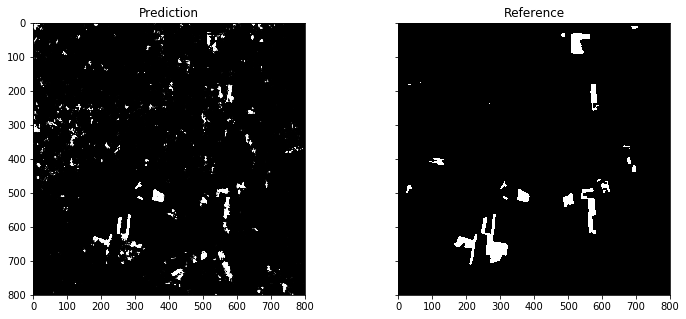

In [23]:
#------------------------
# Test
#------------------------    
# Evaluation
print('evaluation process...')
expt.test(data_dir=data_dir, subUL=subUL, 
          band_ind=band_ind, block_size=block_size)  # lr_block_size=lr_block_size
#    for test_set in param['test_sets']:
#        expt.test(test_set=test_set, lr_block_size=lr_block_size)
